In [87]:
from itertools import chain
from collections import defaultdict, Counter

import pandas as pd
import numpy as np

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import warnings
warnings.filterwarnings("ignore")

# Accuracy ap

In [88]:
df = pd.read_csv('../data/fingerprinting_2.csv', index_col='Unnamed: 0')
df = df.reset_index(drop=True)
df

,Server-RSSI-1,Server-RSSI-2,Server-RSSI-3,Server-RSSI-4,Server-RSSI-5,Square,Point,Orientation
0,-55,-71,-69,-57,-58,s0,0,0.0
1,-57,-64,-58,-48,-58,s0,0,0.0
2,-57,-64,-58,-48,-58,s0,0,0.0
3,-57,-64,-57,-48,-58,s0,0,0.0
4,-57,-65,-57,-48,-58,s0,0,0.0
...,...,...,...,...,...,...,...,...
47795,-63,-51,-58,-52,-51,s7,39,3.0
47796,-63,-51,-58,-52,-51,s7,39,3.0
47797,-62,-51,-58,-52,-51,s7,39,3.0
47798,-63,-51,-58,-52,-51,s7,39,3.0


In [89]:
df.describe()

,Server-RSSI-1,Server-RSSI-2,Server-RSSI-3,Server-RSSI-4,Server-RSSI-5,Point,Orientation
count,47800.000000,47800.000000,47800.000000,47800.000000,47800.000000,47800.000000,47800.000000
mean,-64.429916,-55.746715,-57.900105,-52.644017,-54.673201,19.418410,1.493724
std,6.651648,7.962469,7.449756,7.737755,7.019741,11.498375,1.116155
min,-91.000000,-91.000000,-90.000000,-91.000000,-90.000000,0.000000,0.000000
25%,-68.000000,-60.000000,-63.000000,-57.000000,-59.000000,9.000000,0.000000
50%,-64.000000,-56.000000,-57.000000,-51.000000,-54.000000,19.000000,1.000000
75%,-60.000000,-51.000000,-53.000000,-48.000000,-50.000000,29.000000,2.000000
max,-48.000000,-30.000000,-36.000000,-34.000000,-34.000000,39.000000,3.000000


In [90]:
grouped = df.groupby(["Point"])
values = np.array([])
for i in range(40):
    grp = grouped.get_group(i)
    for j in ["Server-RSSI-1","Server-RSSI-2","Server-RSSI-3","Server-RSSI-4","Server-RSSI-5"]:
        mean = grp[j].mean()
        values = np.append(values,(grp[j]-mean).to_numpy())
values.shape

(239000,)

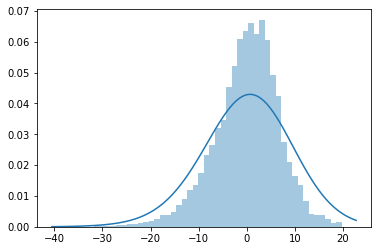

In [91]:
sns.distplot(values,kde_kws={'bw':1})

In [92]:
from sklearn.metrics import mean_absolute_error
mean=values.mean()
mean_absolute_error([mean for _ in range(values.size)],values)

5.207785235704324

In [93]:
from scipy.stats import normaltest

k2,p = normaltest(values)
p

0.0

In [94]:
values = np.sort(values)
x = values[np.where(values == np.percentile(values,5))[0][0]:np.where(values == np.percentile(values,95))[0][0]]

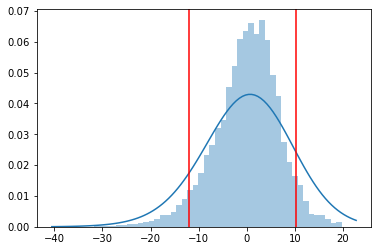

In [95]:
sns.distplot(values,kde_kws={'bw':1})
plt.axvline(np.percentile(values,5), 0,10,color='red')
plt.axvline(np.percentile(values,95), 0,10,color='red')

In [96]:
mean_x = x.mean()
mean_absolute_error([mean_x for _ in range(x.size)],x)

4.147382095664195

In [97]:
def init_figure(x=(-1,8),y=(-1,8),width=1000,height=1000):
    fig = go.Figure()
    fig.update_xaxes(range=x, showline=True)
    fig.update_yaxes(range=y,showline=True)
    fig.update_layout(
        autosize=False,
        width=width,
        height=height
    )
    fig.update_layout(showlegend=False)
    return fig
def add_circle(fig,radius,center = (0,0),color="LightSeaGreen"):
    fig.add_trace(go.Scatter(
    x=(center[0],),
    y=(center[1],),
    mode="markers",
    line_color=color
))
    fig.add_shape(
                type="circle",
                xref="x",
                yref="y",
                x0=center[0]-radius,
                y0=center[1]-radius,
                x1=center[0]+radius,
                y1=center[1]+radius,
                line_color=color
    )
def add_beacon_circles(fig,accuracies,center = (0,0),color="LightSeaGreen"):
    for acc in accuracies:
        add_circle(fig,acc,center,color)

In [98]:
fig=init_figure()
beacons = [(0,-0.25),(4,-0.35),(0,4.2)]
colors = ["LightSeaGreen","#ff7f0e","#9467bd"]
for b in range(3):
    add_beacon_circles(fig,[0.05,0.1,0.25,0.7,2,5],beacons[b],colors[b])
fig.show()

#  Approximating theoretical maximum accuracy

We know, that $RSSI = 11 \lg \frac{P}{P_0}$

So, knowing, that intensity is the power transfered per unit area, and by having power in numenator and denominator, we can conclude, that $RSSI = 10 \lg \frac{\mathcal{I}}{\mathcal{I}_0}$  

Due to Inverse-square law we know, that $\mathcal{I} \propto \frac{1}{r^2}$:

So, $\mathcal{I} = \frac{c}{r^2}$

$RSSI = 10 \lg \mathcal{I} - 10 \lg \mathcal{I_0} = 
10 \lg{\frac{c}{r^2}} - 10 \lg{\mathcal{I_0}} =
-20 \lg{r} + 10 \lg{c} - 10 \lg{\mathcal{I_0}}$

Let's substitute $\mathcal{C} = 10 \lg{c} - 10 \lg{\mathcal{I_0}}$, as
it don't depends on distance and is constant


$RSSI = -20 \lg r + \mathcal{C}$  

So let's find the range of distance, that can correspond to same value of RSSI.  
We will use next charachteristics of kit (CY8CPROTO-063-BLE), that we are using:
 - Resolution in 1 db
 - Accuracy in 4 db

So we will create sequence of distance [0.01 - 10] m, 
and then finding corresponding RSSI. After that we will create groups with rssi values, that are in
range [c-accuracy, c+accuracy]. So this group will map to the distance interval and we will
assume, that we cannot distinguish rssi's on this interval. 

##  1-dimensional case

In [99]:
@np.vectorize

def rssi_from_distance(d):
    return -20*np.log10(d)


def get_bins_according_to_accuracy(rssi, accuracy):
    bins = np.arange(rssi.min(), rssi.max())
    group_size = int(accuracy*2 + 1)

    

    split_indeces = list(range(group_size, bins.shape[0], group_size))
    if split_indeces[-1] != bins.shape[0] - 1:
        split_indeces.append(bins.shape[0]-1)

        

    bins = np.split(bins, split_indeces)
    bins=np.fromiter(map(np.mean, bins), dtype=float)

    return [ bins[abs(bins - rssi[i]).argmin()] for i in range(rssi.shape[0])]


def get_intervals_with_same_rssi(rssi_bins, dist_bins):
    rssi_to_dist_map = defaultdict(list)
    for rssi, dist in zip(rssi_bins, dist_bins):
        rssi_to_dist_map[rssi].append(dist)
    return np.array([(min(distances), max(distances)) for distances in rssi_to_dist_map.values()])

def get_radiuses_for_distance_contour_lines(intervals):
    radiuses = np.array([end for st, end in intervals])
    return radiuses

Distance steps: [0.01 0.02 0.05 0.16 0.47 1.33 3.75 9.99]


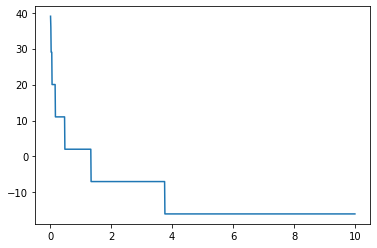

In [100]:
distances = np.arange(0.01, 10, 0.01)
rssi = rssi_from_distance(distances)

rssi_bins = get_bins_according_to_accuracy(rssi, 4)

sns.lineplot(x=distances, y=rssi_bins)

intervals = get_intervals_with_same_rssi(rssi_bins, distances)
radiuses = get_radiuses_for_distance_contour_lines(intervals)

print("Distance steps:", radiuses)

##  2-dimensional case

###  Define local enviroment constants

In [231]:
x_len = 3
y_len = 4

beacon_number = 5
beacons_location = np.array([[0.0, -0.2], [3.5, 0.25], [3.5, 2],[3.5,4.3],[0,4.2]])

###  Generate Grid of points

In [232]:
def cartesian_cross_product(x,y):
    cross_product = np.transpose([np.tile(x, len(y)),np.repeat(y,len(x))])
    return cross_product

delta = 0.01
points = cartesian_cross_product(np.arange(0, x_len, delta), np.arange(0, y_len, delta))

###  Group points by the same RSSI regions

In [233]:
def distance(p1, p2):
    def helper(p1, p2):
        return (((p1[:,0] - p2[0])**2 + (p1[:,1] - p2[1])**2)**0.5)
    vectorized_distance = np.vectorize(helper, signature='(n,m),(m)->(n)')
    
    return np.apply_along_axis(lambda x: vectorized_distance(p1, x), 1, p2)

distance = np.vectorize(distance, signature='(n,m),(k,m)->(k,n)')

@np.vectorize
def find_interval_num(dist):
    return (dist > radiuses).argmin() - 1

def find_point_flag(p, beacons_location, radiuses):
    return find_interval_num(distance(p, beacons_location).T)

find_point_flag = np.vectorize(find_point_flag, signature='(n,m),(i,m),(j)->(n,i)')

In [234]:
point_flags = find_point_flag(points, beacons_location, radiuses)

points_grouped_list = defaultdict(list)
for i in range(point_flags.shape[0]):
     points_grouped_list[tuple(point_flags[i])].append(points[i])

points_grouped = dict()
for group in points_grouped_list.keys():
    points_grouped[group] = np.array(points_grouped_list[group])

###  Get rid of small regions

In [235]:
minimum_radius = 0.1

min_group = np.asscalar(find_interval_num(minimum_radius))

points_grouped_without_small = dict(filter(lambda x: all(map(lambda x: x >= min_group, x[0])), points_grouped.items()))

###  Calculate accuracy

In [236]:
def accuracy_by_box(points):
    x_boundary = np.array([min(points, key=lambda x: x[0])[0], max(points, key=lambda x: x[0])[0]])
    y_boundary = np.array([min(points, key=lambda x: x[1])[1], max(points, key=lambda x: x[1])[1]])

    minima, maxima = np.concatenate([x_boundary.reshape(1, -1), y_boundary.reshape(1, -1)]).T
    return np.asscalar(distance(minima.reshape(1,-1), maxima.reshape(1,-1)))/2

def accuracy_by_mean_dist(points):
    return np.mean(distance(points, points))

In [237]:
region_accuracy_by_box = dict()

for region in points_grouped_without_small.items():
    region_accuracy_by_box[region[0]] = accuracy_by_box(region[1])

In [22]:
region_accuracy_by_mean_dist = dict()

for region in points_grouped_without_small.items():
    region_accuracy_by_mean_dist[region[0]] = accuracy_by_mean_dist(region[1])

In [23]:
accuracies = np.array([np.fromiter(chain(region_accuracy_by_box.values()), float),

                       np.fromiter(chain(region_accuracy_by_mean_dist.values()), float)])

NameError: name 'region_accuracy_by_mean_dist' is not defined

In [24]:
cont = plt.bar(x=range(accuracies.shape[1]), height=accuracies[0,:])
cont = plt.bar(x=range(accuracies.shape[1]), height=accuracies[1,:])

plt.legend(["Half length from minima and maxima", "Mean distance between points"])
plt.ylabel("Accuracy")
plt.xlabel("Number of Group")

NameError: name 'accuracies' is not defined

In [25]:
print("Mean accuracy using half length of minima and maxima: {:.2}".format(np.mean(accuracies[0])))
print("Mean accuracy using mean distance between points: {:.2}".format(np.mean(accuracies[1])))

NameError: name 'accuracies' is not defined

In [238]:
field = np.zeros((x_len*100,y_len*100))
for reg, points in points_grouped_without_small.items():
    for point in points:
        field[int(round(point[0]*100))][int(round(point[1]*100))] = region_accuracy_by_box[reg]

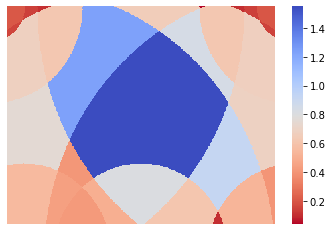

In [239]:
sns.heatmap(field,xticklabels=False,yticklabels=False,cmap="coolwarm_r")